# 1. 삼성전자 주식 예측

### STEP 1 : 시계열 데이터 준비

In [22]:
import numpy as np   
import pandas as pd  
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

#라이브러리 버전 확인
print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)

1.3.3
1.0
0.13.0


In [12]:
# 삼성전자 주식 데이터셋 불러오기
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv' 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)  
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

### STEP 2 : 각종 전처리 수행

In [13]:
    # 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

결과값으로 보여 결측치가 없다.

In [107]:
    # 로그 변환 
ts_log = np.log(ts)

### STEP 3 : 시계열 안정성 분석

In [23]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열
        
     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

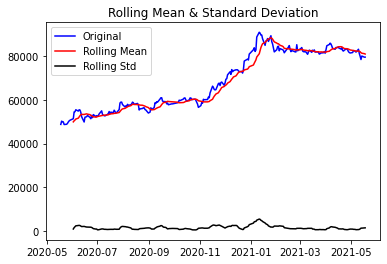

In [16]:
plot_rolling_statistics(ts, window=12)

Augmented Dickey-Fuller Test(ADF Test)<br> 
1. 주어진 시계열 데이터가 안정적이지 않다라는 귀무가설(Null Hypothesis)를 세운 후 
2.통계적 가설 검정 과정을 통해 이 귀무가설이 기각될 경우에
3.이 시계열 데이터가 안정적이다라는 대립가설(Alternative Hypothesis)을 채택한다



In [ ]:
#statsmodels 패키지에서 제공하는 adfuller 메서드를 이용
#주어진 timeseries에 대한 Augmented Dickey-Fuller Test를 수행하는 코드

from statsmodels.tsa.stattools import adfuller
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [17]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.222649
p-value                          0.663778
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


p-value 가 0.05를 넘음.<br>
'ts 시계열이 안정적이지 않다'라는 귀무가설을 완벽히 기각할수 없게 됨 -> 이 시계열이 안정적이라고 주장할 수 없음.<br>
안정적이지 않은 시계열을 분석하려면 이것을 안정적인 시계열로 바꾸어 내야 함.<br>

    1. 정성적 분석을 통해 기존의 시계열 데이터를 가공/변형
    2. 시계열 분해(Time series decomposition) 기법 적용

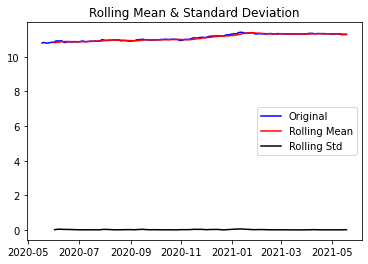

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


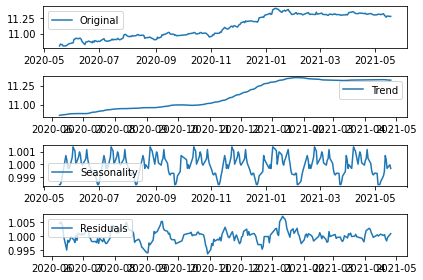

In [18]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

p-value가 0.05를 넘어 안정적이라고 말할수 없음

In [19]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


Residual의 p-value는 0.05 이하라서 안정적이다.

### STEP 4 : 학습, 테스트 데이터셋 생성

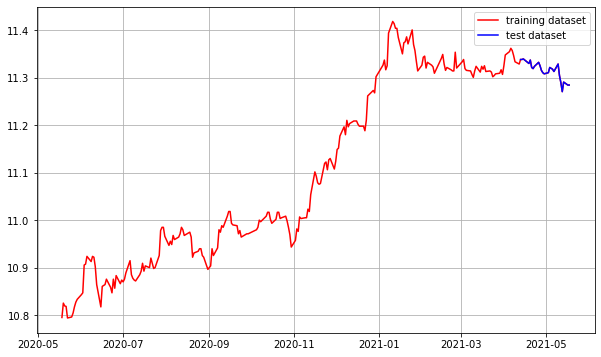

In [20]:
#train-test data split
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### STEP 5 : 적정 ARIMA 모수 찾기

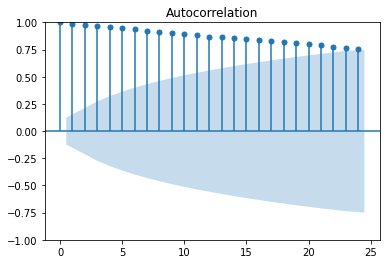

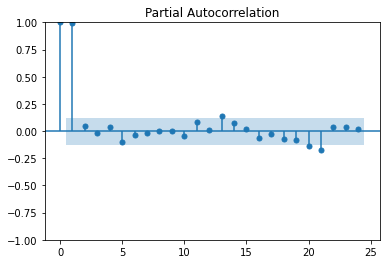

In [24]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

p가 2 이상인 구간에서 PACP는 0에 가깝다.. 따라서 p=1이 적당할 것.<br>
ACP는 점차적으로 감소하고 있고 p가 1이기 때문에(p+q<2, p*q=0) q=0일 것으로 추정.

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


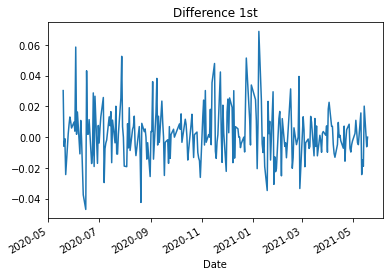

In [36]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

1차 차분의 p-value가 매우 작으므로 안정적이다. d=1

### STEP 6 : ARIMA 모델 훈련과 테스트

In [71]:
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 0, 1))
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 619.797
Date:                Thu, 28 Apr 2022   AIC                          -1231.594
Time:                        09:17:11   BIC                          -1217.894
Sample:                             0   HQIC                         -1226.066
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.8926      0.024    328.259      0.000       7.845       7.940
ar.L1          0.9656      0.016     59.630      0.000       0.934       0.997
ma.L1          0.0470      0.066      0.716      0.4

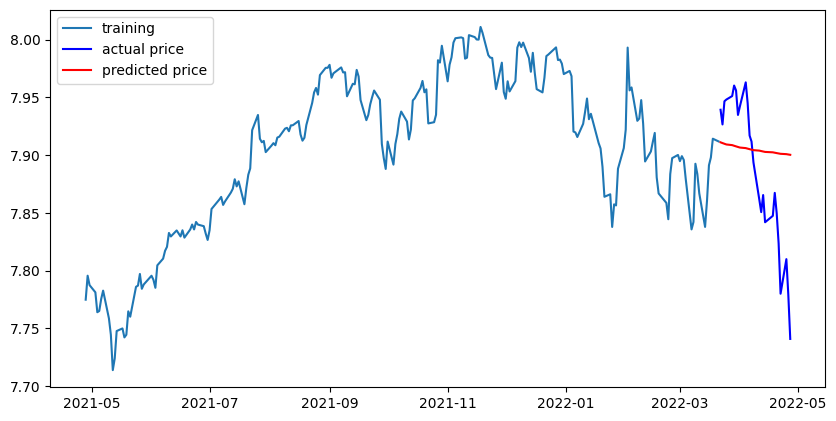

In [72]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [70]:
#시계열 데이터를 로그 변환하여 사용했으므로 다시 지수 변환해야 정확한 오차를 계산할 수 있다

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

#np.exp()를 통해 전부 원본 스케일로 돌린 후 MSE, MAE, RMSE, MAPE를 계산
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  26355.469350995772
MAE:  138.82609614329024
RMSE:  162.34367665848822
MAPE: 5.36%


MAPE가 5%대의 정확성을 보였다. 

# STEP 7 : 다른 주식 종목 예측해 보기

# 2. Alphabet Inc. (GOOG) 주식 예측

### STEP 1 : 시계열 데이터 준비 

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

In [78]:
# 구글 주식 데이터셋 불러오기
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/GOOG.csv' 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)  
google_ts = df['Close']

google_ts.head()

Date
2021-04-28    2379.909912
2021-04-29    2429.889893
2021-04-30    2410.120117
2021-05-03    2395.169922
2021-05-04    2354.250000
Name: Close, dtype: float64

### STEP 2 : 각종 전처리 수행

In [42]:
    # 결측치 처리
google_ts = ts.interpolate(method='time')
google_ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

결측치 없음

In [50]:
    # 로그 변환 
google_ts_log = np.log(ts)

### STEP 3 : 시계열 안정성 분석

In [44]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열
        
     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

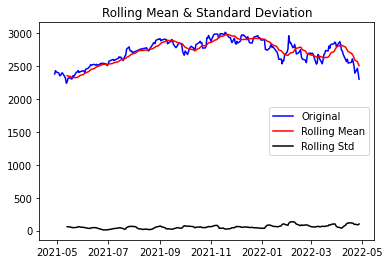

In [45]:
plot_rolling_statistics(google_ts, window=12)

In [46]:
# Augmented Dickey-Fuller Test(ADF Test) 

from statsmodels.tsa.stattools import adfuller
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [89]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.715356
p-value                          0.423219
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


p-value 가 0.05를 넘음.<br>
'ts 시계열이 안정적이지 않다'라는 귀무가설을 완벽히 기각할수 없게 됨 -> 이 시계열이 안정적이라고 주장할 수 없음.<br>

안정적이지 않은 시계열을 분석하려면 이것을 안정적인 시계열로 바꾸어 내야 함.<br>

    1. 정성적 분석을 통해 기존의 시계열 데이터를 가공/변형
    2. 시계열 분해(Time series decomposition) 기법 적용

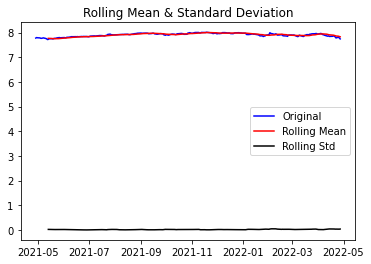

Results of Dickey-Fuller Test:
Test Statistic                  -1.635405
p-value                          0.464663
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


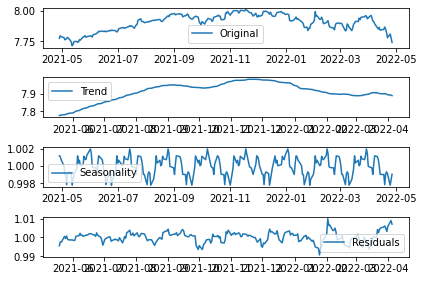

In [51]:
# 정성적 그래프 분석
plot_rolling_statistics(google_ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(google_ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(google_ts_log, model='multiplicative', period = 30)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

p-value가 0.05를 넘어 안정적이라고 말할수 없음

In [52]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.149194
p-value                          0.000011
#Lags Used                       5.000000
Number of Observations Used    217.000000
Critical Value (1%)             -3.460849
Critical Value (5%)             -2.874953
Critical Value (10%)            -2.573919
dtype: float64


## STEP 4 : 학습, 테스트 데이터셋 생성

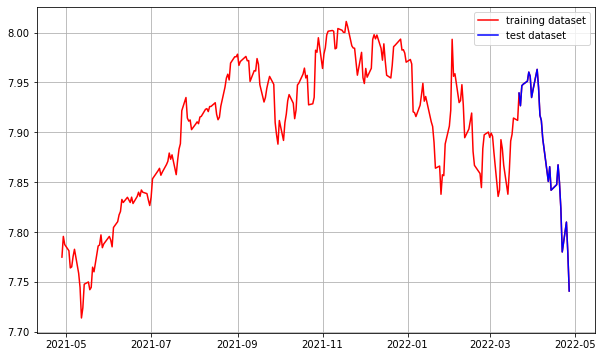

In [53]:
    #train-test data split
train_data, test_data = google_ts_log[:int(len(google_ts_log)*0.9)], google_ts_log[int(len(google_ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## STEP 5 : 적정 ARIMA 모수 찾기

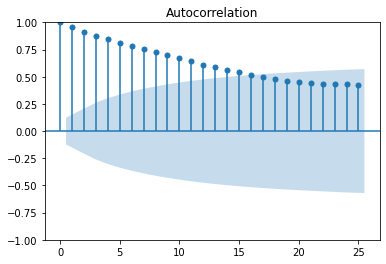

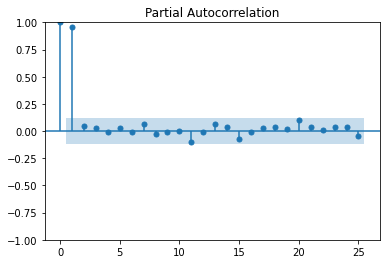

In [54]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

p가 2 이상인 구간에서 PACP는 0에 가깝다.. 따라서 p=1이 적당.
<br>ACP는 점차적으로 감소하고 있고 p가 1이기 때문에(p+q<2, p*q=0) q=0일 것으로 추정.

Results of Dickey-Fuller Test:
Test Statistic                -1.528496e+01
p-value                        4.524215e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64


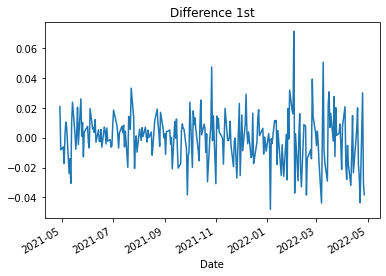

In [55]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

1차 차분의 p-value가 매우 작으므로 안정적이다. d=1

## STEP 6 : ARIMA 모델 훈련과 테스트

In [73]:
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 0, 1))
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 619.797
Date:                Thu, 28 Apr 2022   AIC                          -1231.594
Time:                        09:18:18   BIC                          -1217.894
Sample:                             0   HQIC                         -1226.066
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.8926      0.024    328.259      0.000       7.845       7.940
ar.L1          0.9656      0.016     59.630      0.000       0.934       0.997
ma.L1          0.0470      0.066      0.716      0.4

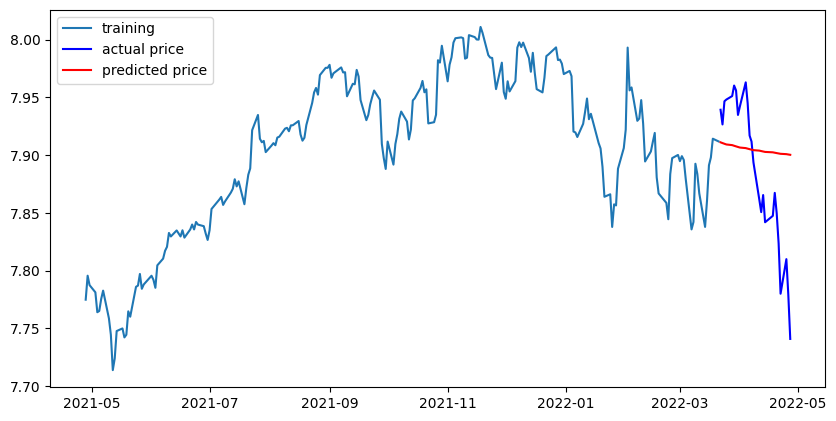

In [74]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [75]:
#시계열 데이터를 로그 변환하여 사용했으므로 다시 지수 변환해야 정확한 오차를 계산할 수 있다

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

#np.exp()를 통해 전부 원본 스케일로 돌린 후 MSE, MAE, RMSE, MAPE를 계산
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  26887.794869533172
MAE:  138.1695059027498
RMSE:  163.97498245016882
MAPE: 5.37%


MAPE가 5%대 정확성을 보였다. 

# 3. 테슬라 주식 예측

## STEP 1 : 시계열 데이터 준비

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [105]:
# 테슬라 주식 데이터셋 불러오기
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/TSLA.csv' 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)  
ts = df['Close']

ts.head()

Date
2021-04-28    694.400024
2021-04-29    677.000000
2021-04-30    709.440002
2021-05-03    684.900024
2021-05-04    673.599976
Name: Close, dtype: float64

## STEP 2 : 각종 전처리 수행

In [106]:
    # 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

결과값으로 보여 결측치가 없다.

In [108]:
    # 로그 변환 
ts_log = np.log(ts)

## STEP 3 : 시계열 안정성 분석

In [109]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열
        
     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

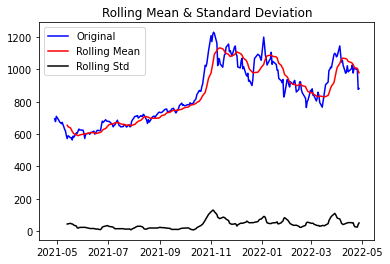

In [110]:
plot_rolling_statistics(ts, window=12)

In [111]:
# Augmented Dickey-Fuller Test(ADF Test) 

#statsmodels 패키지에서 제공하는 adfuller 메서드를 이용
#주어진 timeseries에 대한 Augmented Dickey-Fuller Test를 수행하는 코드

from statsmodels.tsa.stattools import adfuller
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [112]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.743318
p-value                          0.408943
#Lags Used                       8.000000
Number of Observations Used    244.000000
Critical Value (1%)             -3.457438
Critical Value (5%)             -2.873459
Critical Value (10%)            -2.573122
dtype: float64


p-value 가 0.05를 넘음.<br>
'ts 시계열이 안정적이지 않다'라는 귀무가설을 완벽히 기각할수 없게 됨 -> 이 시계열이 안정적이라고 주장할 수 없음.<br>

안정적이지 않은 시계열을 분석하려면 이것을 안정적인 시계열로 바꾸어 내야 함.<br>

    1. 정성적 분석을 통해 기존의 시계열 데이터를 가공/변형
    2. 시계열 분해(Time series decomposition) 기법 적용

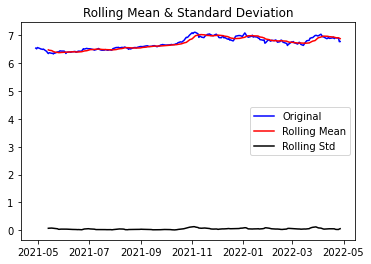

Results of Dickey-Fuller Test:
Test Statistic                  -1.417388
p-value                          0.573912
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


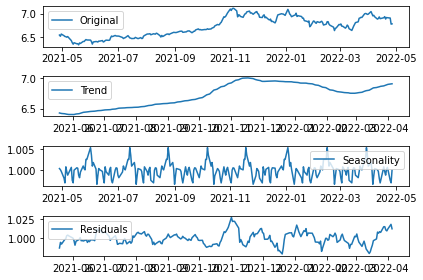

In [113]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

p-value가 0.05를 넘어 안정적이라고 말할수 없음

In [114]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.366543e+00
p-value                        2.402093e-08
#Lags Used                     7.000000e+00
Number of Observations Used    2.150000e+02
Critical Value (1%)           -3.461136e+00
Critical Value (5%)           -2.875079e+00
Critical Value (10%)          -2.573986e+00
dtype: float64


Residual의 p-value는 0.05 이하라서 안정적이다.

## STEP 4 : 학습, 테스트 데이터셋 생성

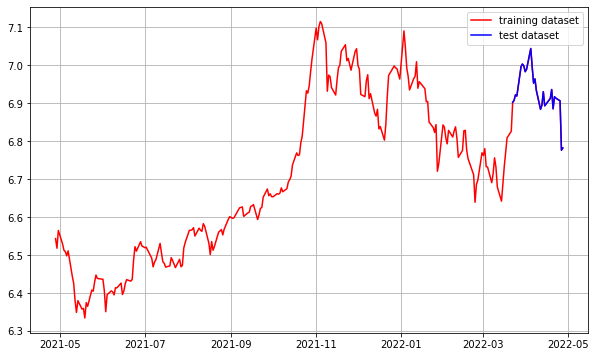

In [115]:
#train-test data split
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## STEP 5 : 적정 ARIMA 모수 찾기

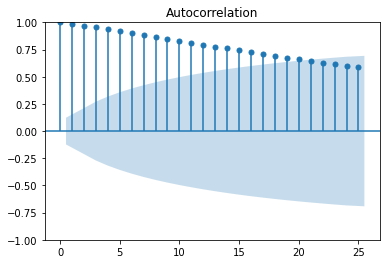

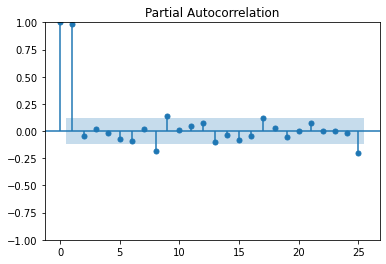

In [116]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

p가 2 이상인 구간에서 PACP는 0에 가깝다.. 따라서 p=1이 적당할 것.
<br> ACP는 점차적으로 감소하고 있고 p가 1이기 때문에(p+q<2, p*q=0) q=0일 것으로 추정.

Results of Dickey-Fuller Test:
Test Statistic                -1.558187e+01
p-value                        1.928095e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64


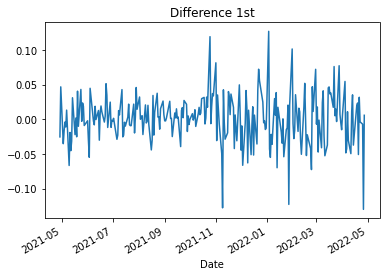

In [117]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

1차 차분의 p-value가 매우 작으므로 안정적이다. d=1

## STEP 6 : ARIMA 모델 훈련과 테스트

In [118]:
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 0, 1))
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 447.385
Date:                Thu, 28 Apr 2022   AIC                           -886.769
Time:                        09:44:53   BIC                           -873.070
Sample:                             0   HQIC                          -881.241
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.6929      0.164     40.933      0.000       6.372       7.013
ar.L1          0.9862      0.011     86.175      0.000       0.964       1.009
ma.L1          0.0309      0.067      0.461      0.6

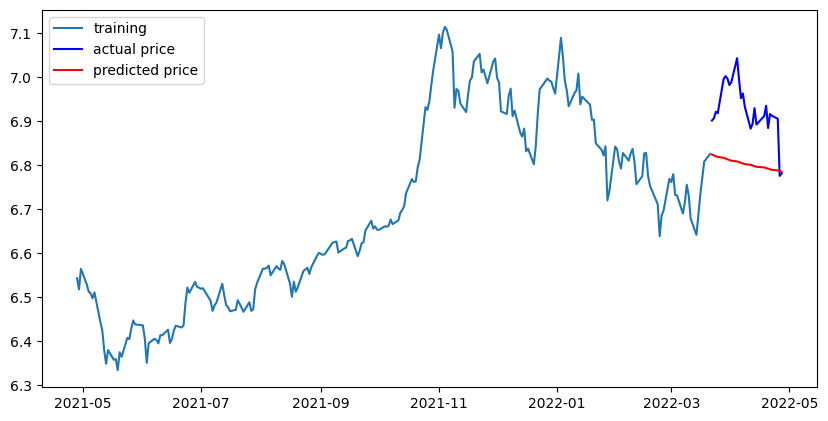

In [119]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [120]:
#시계열 데이터를 로그 변환하여 사용했으므로 다시 지수 변환해야 정확한 오차를 계산할 수 있다

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

#np.exp()를 통해 전부 원본 스케일로 돌린 후 MSE, MAE, RMSE, MAPE를 계산
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  17699.171586854143
MAE:  121.88164842137652
RMSE:  133.03823355281799
MAPE: 11.65%


MAPE: 11%대가 나왔다. 시각적으론 앞의 두 회사의 주가보다 더 예측을 잘 한것 같은데 실제 데이터 상으론 아닌듯 하다.

## 회고

노드를 참고하여 코드를 하나하나 한줄한줄 천천히 따라가 보았다.<br>
와인분류 당뇨예측 등 이전의 프로젝트보다 그래프가 많고 딱딱하게 느껴져 재미가 없었다. <br>
하지만 역시 적응의 동물답게 익숙해졌다. <br>
특히 주식 예측 모델이라.. 잘 발전시키면 미래에 유용한 수단이 될듯한데?! <br> 
연도의 범위를 늘려 2008년 리먼브라더스나 2020년 코로나 사태같은 주식시장의 emergency가 있던 시기도 포함시켜봤더니 예측율이 확실히 감소했다. <br>
모수 판별법이 tricky 했다. 노드도 명확한 기준점과 그 근거를 제시하기보단 이거 아니면 저거 식으로 설명되어 있었다. <br>
노드 내용과 내 그래프가 일치하면 모수를 그대로 따라가고 반대면 모수도 반대로 설정했다. <br>
p-value, 통계학 자체가 주관적인 요소가 들어있어 절대적 기준을 제시하기 어렵기 때문에 어쩔수 없다는 생각이 들었다.